In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error as mae
from sklearn.preprocessing import StandardScaler

from keras.models import Model
from keras.layers import Input, LSTM, GRU, SimpleRNN, Dense
import keras.backend as K
from keras.optimizers import SGD, Adam

Using TensorFlow backend.


In [ ]:
# get the data
df = pd.read_csv('https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/tf2.0/sbux.csv')

In [ ]:
df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX


In [ ]:
# get the close price
series = df['close'].values.reshape(-1, 1)

In [ ]:
# Normalize the data
# Note: I didn't think about where the true boundary is, this is just approx.
scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

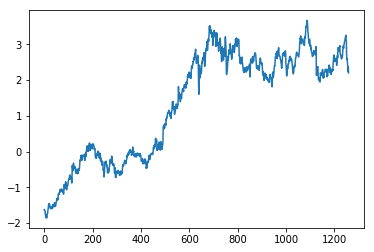

In [ ]:
# plot it
plt.plot(series)
plt.show()

In [ ]:
### build the dataset
# let's see if we can use T past values to predict the next value
T = 10
D = 1
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1)
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (1249, 10, 1) Y.shape (1249,)


In [ ]:
# split into train and test
Xtrain, Ytrain = X[:-N//2], Y[:-N//2]
Xtest, Ytest = X[-N//2:], Y[-N//2:]

In [ ]:
### try autoregressive RNN model
i = Input(shape=(T, 1))

# multiple LSTMs
# x = LSTM(5, return_sequences=True)(i)
# x = LSTM(5, return_sequences=True)(x)
# x = LSTM(5)(x)

# one LSTM
x = LSTM(5)(i)

x = Dense(1)(x)
model = Model(i, x)
model.compile(
  loss='mse',
  optimizer=Adam(lr=0.01),
)

In [ ]:
# train the RNN
r = model.fit(
  Xtrain, Ytrain,
  epochs=80,
  validation_data=(Xtest, Ytest),
)

Train on 624 samples, validate on 625 samples
Epoch 1/80
624/624 [==============================] - 4s 6ms/step - loss: 0.7804 - val_loss: 1.6897
Epoch 2/80
624/624 [==============================] - 1s 1ms/step - loss: 0.1240 - val_loss: 0.2669
Epoch 3/80
624/624 [==============================] - 1s 1ms/step - loss: 0.0521 - val_loss: 0.4295
Epoch 4/80
624/624 [==============================] - 1s 1ms/step - loss: 0.0269 - val_loss: 0.1569
Epoch 5/80
624/624 [==============================] - 1s 1ms/step - loss: 0.0152 - val_loss: 0.0998
Epoch 6/80
624/624 [==============================] - 1s 1ms/step - loss: 0.0103 - val_loss: 0.0549
Epoch 7/80
624/624 [==============================] - 1s 1ms/step - loss: 0.0084 - val_loss: 0.0560
Epoch 8/80
624/624 [==============================] - 1s 1ms/step - loss: 0.0077 - val_loss: 0.0532
Epoch 9/80
624/624 [==============================] - 1s 999us/step - loss: 0.0072 - val_loss: 0.0514
Epoch 10/80
624/624 [==============================]

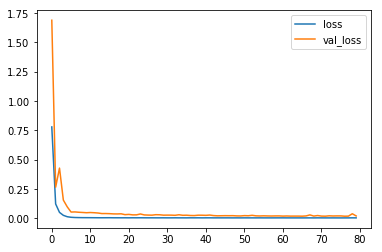

In [ ]:
# Plot loss per iteration
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [ ]:
# Make predictions
Ptrain = model.predict(Xtrain)
Ptest = model.predict(Xtest)

In [ ]:
# inverse transform
Ytrain2 = scaler.inverse_transform(Ytrain.reshape(-1, 1)).flatten()
Ytest2 = scaler.inverse_transform(Ytest.reshape(-1, 1)).flatten()
Ptrain2 = scaler.inverse_transform(Ptrain.reshape(-1, 1)).flatten()
Ptest2 = scaler.inverse_transform(Ptest.reshape(-1, 1)).flatten()

In [ ]:
# Print the MAE
print("lstm train mae:", mae(Ytrain2, Ptrain2))
print("lstm test mae:", mae(Ytest2, Ptest2))

lstm train mae: 0.3534254822853285
lstm test mae: 0.7378289543457031


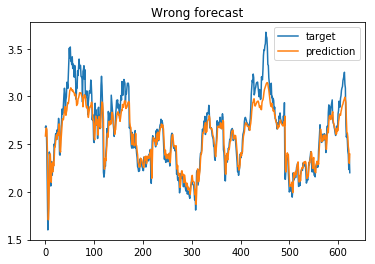

In [ ]:
# wrong forecast
plt.plot(Ytest, label='target')
plt.plot(Ptest, label='prediction')
plt.legend()
plt.title("Wrong forecast")
plt.show()

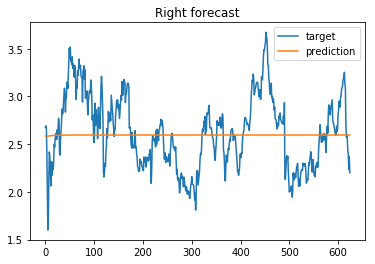

In [ ]:
# right forecast
forecast = []
input_ = Xtest[0]
while len(forecast) < len(Ytest):
  f = model.predict(input_.reshape(1, T, 1))[0,0]
  forecast.append(f)

  # make a new input with the latest forecast
  input_ = np.roll(input_, -1)
  input_[-1] = f
plt.plot(Ytest, label='target')
plt.plot(forecast, label='prediction')
plt.legend()
plt.title("Right forecast")
plt.show()